# Проект. Прогнозирование количества заказов такси
## Глава 0. Входные данные

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#### Путь к файлу:
- /datasets/taxi.csv

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Глава 1. Загрузка и подготовка данных

Вызовем библиотеки, необходимые для реализации проекта:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл, создадим ДатаФрейм, выведем таблицу. Столбец `datetime` приведем к формату даты и переведем в индекс через `index_col`, `parse_dates`:

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Выведем информацию о таблице через метод `.info()`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индексы по возрастанию даты:

In [4]:
df.sort_index(inplace=True)

Проверим, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы `is_monotonic`:

In [5]:
df.index.is_monotonic

True

Построим график временного ряда

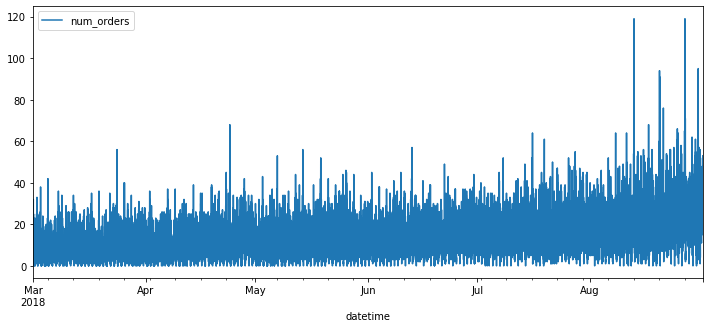

In [6]:
df.plot(figsize=(12,5));

Проведем Ресемплирование - изменение временного ряда на часовой и вычислим агрегированное значение ряда по `.sum()`:

In [7]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Посмотрим на тренд и сезонность данных с помощью функции `seasonal_decompose()`. Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток

In [8]:
decomposed = seasonal_decompose(df)

Построим 3 графика:

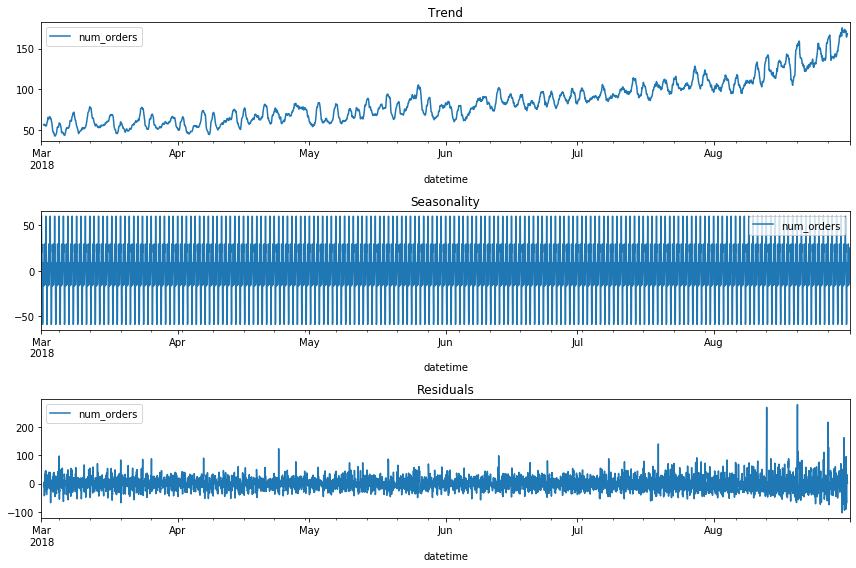

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

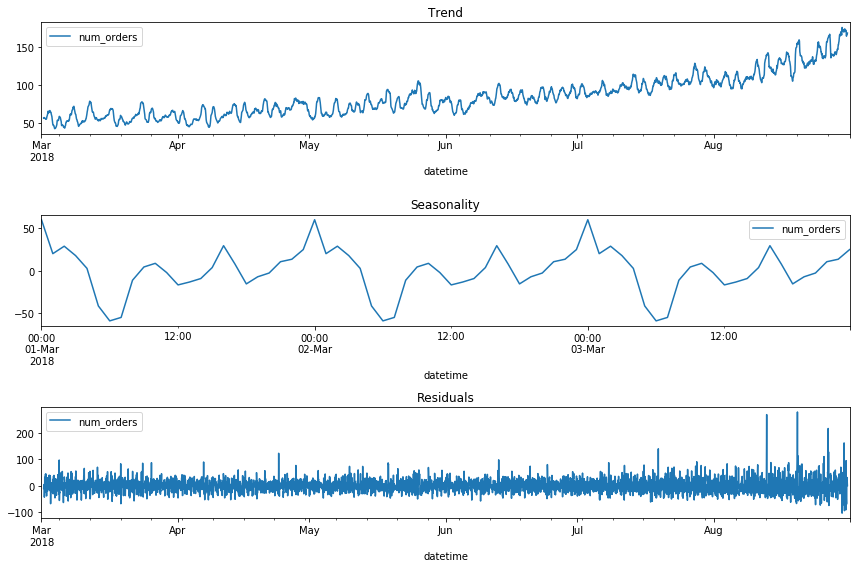

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику сезонности можно отметить переодичность: пик загрузки приходится в полночь, минимум в 6 утра. Также наблюдается локальный максимум днем. 

### Выводы по главе 1:

> В процессе загрузки и обработки данных обнаружили:  
- Среднее меняется с течением времени. Данные представляют собой нестационарный временной ряд. Прогнозировать такие ряды сложнее: свойства меняются слишком быстро.

## Глава 2. Анализ

Напишем функцию **make_features()**, Чтобы ряд сделать стационарным, найдём разности его значений, чтобы прибавить к таблице новых календарные признаки: месяц, день, день недели и час. Также отстающие значения с помощью функции `shift()`: 'lag_1', 'lag_2' — и до величины max_lag, признаки Скользящая средняя и стандартное отклонение:

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['difference'] = abs(data['num_orders'] - data['num_orders'].shift())
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for i in range(1, max_lag + 1):
        data['lag_' + str(i)] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()

make_features(df, 10, 10)

Выведем ДатаФрейм с новыми признаками:

In [16]:
df

,num_orders,difference,month,day,dayofweek,hour,lag_1,rolling_mean,std,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,39.0,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,14.0,3,1,3,2,85.0,NaN,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,5.0,3,1,3,3,71.0,NaN,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,23.0,3,1,3,4,66.0,NaN,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,71.0,8,31,4,19,207.0,173.3,35.267391,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0
2018-08-31 20:00:00,154,18.0,8,31,4,20,136.0,166.6,35.362252,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0
2018-08-31 21:00:00,159,5.0,8,31,4,21,154.0,162.9,34.449480,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0


Разделим датафрейм на 3 части: обучающую, вилидационную и тестовую выбороки в пропорциях 3:1:1, используя функцию `train_test_split` из библиетеки `sklearn.model_selection` и удалим пропуски в тестовой выборке, с помощью `.dropna()`

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train, valid = train_test_split(train, shuffle=False, test_size=0.25)
train = train.dropna()

In [18]:
train.shape, valid.shape, test.shape

((2639, 18), (883, 18), (884, 18))

Разделим выборки на `features` -  признаки и `target` — целевой признак.

In [19]:
train_features = train.drop(['num_orders'], axis=1)
valid_features = valid.drop(['num_orders'], axis=1)
test_features = test.drop(['num_orders'], axis=1)

train_target = train['num_orders']
valid_target = valid['num_orders']
test_target = test['num_orders']

Для того, чтобы отмаштабировать признаки, воспользуемся одним из методов масштабирования — стандартизации данных.  
В sklearn есть отдельная структура для стандартизации данных — **StandardScaler**  
Преобразуем обучающую,валидационную и тестовую выборки функцией `transform()`.

In [20]:
scaler = StandardScaler()
scaler.fit(train_features)

train_features = scaler.transform(train_features)
valid_features = scaler.transform(valid_features)
test_features = scaler.transform(test_features)

Напишем функцию оценки качества моделей **RMSE**:

In [21]:
def RMSE(target, predict):
    RMSE = mean_squared_error(target, predict) ** 0.5
    return RMSE

### Выводы по главе 2:

> В процессе анализа:
- Привели временной ряд к стационарному, используя разницу между текущим и предыдущим значениями. Такой временной ряд проще прогнозировать.
- Добавили новые признаки для обучения моделей. Это позволит моделям искать взаимосвязи в данных и лучше обучаться.

## Глава 3. Обучение моделей

Обучим следующие модели для предсказания:
- линейную регресиию **LinearRegression**
- модель стохастического градиентного спуска **SGDRegressor**
- модель градиентного бустинга  **XGBRegressor**
- модель градиентного бустинга  **CatBoostRegressor**
- модель градиентного бустинга  **LGBMRegressor**

Обучать модели и тюнить гиперпараметры будем на обучающей выборке, делать финальное обучение на обучающей и валидационной выборке, чтобы модель обучилась на расширенном объеме данных и смогла сделалать лучше предсказания на тестовой выборке.

Запишем объединенные выборки в переменные **train_valid_features** и **train_valid_target**:

In [48]:
train_valid_features = np.vstack((train_features, valid_features))

In [49]:
train_valid_target = train_target.append(valid_target)

In [50]:
train_valid_features.shape, train_valid_target.shape

((3522, 17), (3522,))

#### 1. Обучим линейную регресиию **LinearRegression**

Импортируем модель:

In [51]:
from sklearn.linear_model import LinearRegression

Созданим объект модель:

In [52]:
LinearReg_model = LinearRegression()

Обучим модель:

In [53]:
%%time
LinearReg_model.fit(train_valid_features, train_valid_target)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 71.9 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Сделаем предсказания для обучающей выборке и найдем функцию потерь модели:

In [54]:
%%time
pred_train_valid = LinearReg_model.predict(train_valid_features)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 80.5 ms


Оценим модель на валидационной выборке по RMSE:

In [55]:
print('RMSE на валидационной выборке: ', RMSE(train_valid_target, pred_train_valid).round(2))

RMSE на валидационной выборке:  28.53


#### 2. Обучим модель стохастического градиентного спуска **SGDRegressor**

Импортируем модель:

In [56]:
from sklearn.linear_model import SGDRegressor

Созданим объект модель:

In [57]:
SGD_LinearReg_model = SGDRegressor(random_state=12345, shuffle=False)
SGD_LinearReg_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Добавим сетку гиперпараметров для обучения:

In [58]:
param_grid = {'alpha' : [0.0001, 0.001],
              'max_iter': [1e3, 1e4, 1e5],
              'eta0': [0.1, 0.01, 0.001]}

Обучим модель по сетке гиперпараметров:

In [59]:
%%time
for i in param_grid['alpha']:
    for j in param_grid['max_iter']:
        for g in param_grid['eta0']:
            SGD_LinearReg_model = SGDRegressor(random_state=12345, shuffle=False, alpha=i, max_iter=j, eta0=g)
            SGD_LinearReg_model.fit(train_features, train_target)
            pred_valid = SGD_LinearReg_model.predict(valid_features)
            print('alpha = {} , max_iter = {}, eta0 = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.1, RMSE на валидационной выборке: 32.26
alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.01, RMSE на валидационной выборке: 32.66
alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.001, RMSE на валидационной выборке: 32.74
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.1, RMSE на валидационной выборке: 32.31
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.01, RMSE на валидационной выборке: 32.66
alpha = 0.0001 , max_iter = 10000.0, eta0 = 0.001, RMSE на валидационной выборке: 32.74
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.1, RMSE на валидационной выборке: 32.31
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.01, RMSE на валидационной выборке: 32.66
alpha = 0.0001 , max_iter = 100000.0, eta0 = 0.001, RMSE на валидационной выборке: 32.74
alpha = 0.001 , max_iter = 1000.0, eta0 = 0.1, RMSE на валидационной выборке: 32.26
alpha = 0.001 , max_iter = 1000.0, eta0 = 0.01, RMSE на валидационной выборке: 32.66
alpha = 0.001 , max_iter = 1000.0, eta0 = 0.001,

Обучим модель на обучающей выборке с найденными гиперпараметрами, сделаем предсказания на валидационной:

In [60]:
SGD_LinearReg_model = SGDRegressor(alpha = 0.0001 , max_iter = 1000.0, eta0 = 0.1, shuffle=False, random_state=12345)

In [61]:
%%time
SGD_LinearReg_model.fit(train_valid_features, train_valid_target)

CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 623 ms


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000.0,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=False, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

#### 3. Обучим модель градиентного бустинга  **XGBRegressor**

In [64]:
from xgboost import XGBRegressor

In [65]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0)
XGBRegressor_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [66]:
param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.3, 0.5]}

In [67]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['n_estimators']:
        for g in param_grid['learning_rate']:
            XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, 
                                              shuffle=False, max_depth=i, n_estimators=j, learning_rate=g)
            XGBRegressor_model.fit(train_features, train_target)
            pred_valid = XGBRegressor_model.predict(valid_features)
            print('max_depth = {} , n_estimators = {}, learning_rate = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

max_depth = 2 , n_estimators = 50, learning_rate = 0.1, RMSE на валидационной выборке: 27.85
max_depth = 2 , n_estimators = 50, learning_rate = 0.3, RMSE на валидационной выборке: 24.22
max_depth = 2 , n_estimators = 50, learning_rate = 0.5, RMSE на валидационной выборке: 23.49
max_depth = 2 , n_estimators = 100, learning_rate = 0.1, RMSE на валидационной выборке: 25.44
max_depth = 2 , n_estimators = 100, learning_rate = 0.3, RMSE на валидационной выборке: 23.11
max_depth = 2 , n_estimators = 100, learning_rate = 0.5, RMSE на валидационной выборке: 23.02
max_depth = 2 , n_estimators = 200, learning_rate = 0.1, RMSE на валидационной выборке: 24.19
max_depth = 2 , n_estimators = 200, learning_rate = 0.3, RMSE на валидационной выборке: 22.89
max_depth = 2 , n_estimators = 200, learning_rate = 0.5, RMSE на валидационной выборке: 23.21
max_depth = 4 , n_estimators = 50, learning_rate = 0.1, RMSE на валидационной выборке: 23.06
max_depth = 4 , n_estimators = 50, learning_rate = 0.3, RMSE на 

In [68]:
XGBRegressor_model = XGBRegressor(n_jobs=-1, verbosity=0, random_state=12345, max_depth = 4 , 
                                  n_estimators = 200, learning_rate = 0.1)

In [69]:
%%time
XGBRegressor_model.fit(train_valid_features, train_valid_target)

CPU times: user 2.21 s, sys: 16 ms, total: 2.23 s
Wall time: 2.2 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

#### 4. Обучим модель градиентного бустинга  CatBoostRegressor

In [70]:
from catboost import CatBoostRegressor

In [71]:
CatBoost_model = CatBoostRegressor(random_state=12345)

In [72]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'iterations': [50, 100, 200]}

In [73]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['learning_rate']:
        for g in param_grid['iterations']:
            CatBoost_model = CatBoostRegressor(random_state=12345, max_depth=i, learning_rate=j, iterations=g)
            CatBoost_model.fit(train_features, train_target, verbose=100)
            pred_valid = CatBoost_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, iterations = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

0:	learn: 32.5752788	total: 68.8ms	remaining: 3.37s
49:	learn: 21.6950706	total: 393ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 50, RMSE на валидационной выборке: 29.1
0:	learn: 32.5752788	total: 1.36ms	remaining: 135ms
99:	learn: 19.8377786	total: 578ms	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 100, RMSE на валидационной выборке: 26.79
0:	learn: 32.5752788	total: 12ms	remaining: 2.38s
100:	learn: 19.7946764	total: 599ms	remaining: 588ms
199:	learn: 17.9268165	total: 1.25s	remaining: 0us
max_depth = 2 , learning_rate = 0.1, iterations = 200, RMSE на валидационной выборке: 25.15
0:	learn: 31.2078314	total: 52.3ms	remaining: 2.56s
49:	learn: 18.5341080	total: 386ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 50, RMSE на валидационной выборке: 25.84
0:	learn: 31.2078314	total: 31.9ms	remaining: 3.15s
99:	learn: 16.6642703	total: 692ms	remaining: 0us
max_depth = 2 , learning_rate = 0.3, iterations = 100, RMSE на валидацион

In [74]:
CatBoost_model = CatBoostRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.1, iterations = 200)

In [75]:
%%time
CatBoost_model.fit(train_valid_features, train_valid_target, verbose=10)

0:	learn: 34.0887921	total: 54ms	remaining: 10.8s
10:	learn: 24.4470391	total: 342ms	remaining: 5.87s
20:	learn: 20.5190987	total: 631ms	remaining: 5.38s
30:	learn: 18.5131278	total: 916ms	remaining: 4.99s
40:	learn: 17.5761237	total: 1.2s	remaining: 4.64s
50:	learn: 16.7875697	total: 1.48s	remaining: 4.31s
60:	learn: 16.1218299	total: 1.75s	remaining: 3.99s
70:	learn: 15.6857449	total: 2.04s	remaining: 3.7s
80:	learn: 15.3354215	total: 2.31s	remaining: 3.39s
90:	learn: 14.9356901	total: 2.59s	remaining: 3.11s
100:	learn: 14.5912719	total: 2.88s	remaining: 2.82s
110:	learn: 14.3121803	total: 3.16s	remaining: 2.53s
120:	learn: 14.0293282	total: 3.44s	remaining: 2.25s
130:	learn: 13.8894466	total: 3.71s	remaining: 1.96s
140:	learn: 13.5834870	total: 3.99s	remaining: 1.67s
150:	learn: 13.2908191	total: 4.27s	remaining: 1.39s
160:	learn: 13.0654714	total: 4.56s	remaining: 1.1s
170:	learn: 12.8525002	total: 4.84s	remaining: 820ms
180:	learn: 12.6512657	total: 5.12s	remaining: 538ms
190:	lea

#### 5. Обучим модель градиентного бустинга  LGBMRegressor

In [76]:
from lightgbm import LGBMRegressor

In [77]:
LGBM_model = LGBMRegressor(random_state=12345)
LGBM_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [80]:
param_grid = {'max_depth': [2, 4, 6],
              'learning_rate': [0.1, 0.3, 0.5],
              'n_estimators': [50, 100, 200]}

In [81]:
%%time
for i in param_grid['max_depth']:
    for j in param_grid['learning_rate']:
        for g in param_grid['n_estimators']:
            LGBM_model = LGBMRegressor(random_state=12345, max_depth=i, learning_rate=j, n_estimators=g)
            LGBM_model.fit(train_features, train_target)
            pred_valid = LGBM_model.predict(valid_features)
            print('max_depth = {} , learning_rate = {}, n_estimators = {}, RMSE на валидационной выборке: {}'
                  .format(i, j, g, RMSE(valid_target, pred_valid).round(2)))

max_depth = 2 , learning_rate = 0.1, n_estimators = 50, RMSE на валидационной выборке: 27.74
max_depth = 2 , learning_rate = 0.1, n_estimators = 100, RMSE на валидационной выборке: 25.14
max_depth = 2 , learning_rate = 0.1, n_estimators = 200, RMSE на валидационной выборке: 23.88
max_depth = 2 , learning_rate = 0.3, n_estimators = 50, RMSE на валидационной выборке: 23.73
max_depth = 2 , learning_rate = 0.3, n_estimators = 100, RMSE на валидационной выборке: 22.92
max_depth = 2 , learning_rate = 0.3, n_estimators = 200, RMSE на валидационной выборке: 22.55
max_depth = 2 , learning_rate = 0.5, n_estimators = 50, RMSE на валидационной выборке: 23.86
max_depth = 2 , learning_rate = 0.5, n_estimators = 100, RMSE на валидационной выборке: 23.3
max_depth = 2 , learning_rate = 0.5, n_estimators = 200, RMSE на валидационной выборке: 23.44
max_depth = 4 , learning_rate = 0.1, n_estimators = 50, RMSE на валидационной выборке: 22.86
max_depth = 4 , learning_rate = 0.1, n_estimators = 100, RMSE на 

In [82]:
LGBM_model = LGBMRegressor(random_state=12345, max_depth = 6 , learning_rate = 0.1, n_estimators = 100)

In [83]:
%%time
LGBM_model.fit(train_valid_features, train_valid_target)

CPU times: user 960 ms, sys: 4 ms, total: 964 ms
Wall time: 973 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Выводы по главе 3:

> В процессе обучения моделей обнаружили:
- на валидационной выборке модели градиентного бустинга имеют примерно равные и лучшие показатели по сравнению с линейной регрессией и стахастическим градиентным бустингом. В тоже время обучения этих моделей требует больших временных затрат.

## Глава 4. Тестирование моделей

Сделаем предсказания моделей на тестовой выборке и оценим их качество:

1 - LinearRegression

In [84]:
%%time
pred_test = LinearReg_model.predict(test_features)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 536 µs


In [85]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  47.82


2 - SGDRegressor

In [86]:
%%time
pred_test = SGD_LinearReg_model.predict(test_features)

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 1.2 ms


In [87]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  48.26


3 - XGBRegressor

In [88]:
%%time
pred_test = XGBRegressor_model.predict(test_features)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 104 ms


In [89]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  40.79


4 - CatBoostRegressor

In [90]:
%%time
pred_test = CatBoost_model.predict(test_features)

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 17.7 ms


In [91]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  42.62


5 - LGBMRegressor

In [92]:
%%time
pred_test = LGBM_model.predict(test_features)

CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 16.7 ms


In [93]:
print('RMSE на тестовой выборке: ', RMSE(test_target, pred_test).round(2))

RMSE на тестовой выборке:  40.99


Сведем все данные в таблицу(скорость обучения и качество метрики):

In [104]:
data = {'Модель':['LinearRegression', 'SGDRegressor', 'XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor'], 
        'Скорость обучения':['71.9 ms', '10.6 s', '8min 26s', '2min 1s', '26min 54s'],
        'Метрика RMSE': [47.82, 48.26, 40.79, 42.62, 40.99]}

In [105]:
df1 = pd.DataFrame(data)
df1

,Модель,Скорость обучения,Метрика RMSE
0,LinearRegression,71.9 ms,47.82
1,SGDRegressor,10.6 s,48.26
2,XGBRegressor,8min 26s,40.79
3,CatBoostRegressor,2min 1s,42.62
4,LGBMRegressor,26min 54s,40.99


### Выводы по главе 4:

> Почти все модели показали результат RMSE ниже 48 на тестовой выборке.  
Модели градиентного бустинга XGBRegressor, CatBoostRegressor, LGBMRegressor показали значительное уменьшение метрики качества.  
Наиболее оптимальными по качеству метрики RMSE является - **XGBRegressor**.  
Наиболее оптимальными по скорости обучения является - **LinearRegression**.  
Наиболее оптимальными в соотношении скорость обучения - качество метрики RMSE - **XGBRegressor**.

### Общий вывод:

По результатам исследований моделей для поставленной задачи наиболее оптимальными являются модели градиентного бустинга:
- XGBRegressor
- CatBoostRegressor
- LGBMRegressor	 

Метрики качества моделей RMSE имеют примерно равные показатели.   
По скорости обучения из этих трех моделей лучшая - CatBoostRegressor.  
По качеству метрики RMSE - XGBRegressor  
Наиболее оптимальной для поставленной задачи "Прогнозирования количество заказов такси на следующий час" является **XGBRegressor**.